(307L, 2L) (307L, 2L) (307L, 1L)
[[ 13.04681517  14.74115241]
 [ 13.40852019  13.7632696 ]
 [ 14.19591481  15.85318113]
 [ 14.91470077  16.17425987]
 [ 13.57669961  14.04284944]]
[[0]
 [0]
 [0]
 [0]
 [0]]


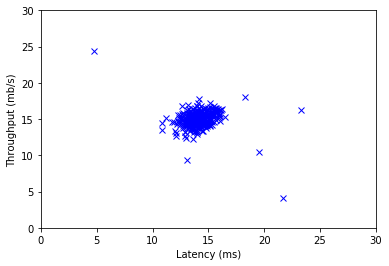

In [2]:
#load data set 
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

data = sio.loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
print X.shape,Xval.shape,yval.shape
print X[:5]
print yval[:5]

plt.plot(X[:,0],X[:,1],'bx')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()




In [3]:
#高斯分布
from scipy import stats

def estimateGaussian(x):
    #train set x fit the mu,sigma2
    m,n = x.shape
    mu = np.mean(x,axis=0).reshape(1,-1)
    #sigma2 = np.sum(np.square(x - mu),axis=0).reshape(1,-1) / m
    sigma2 = np.var(x,axis=0).reshape(1,-1)
    
    return mu,sigma2
    
def p(x,mu,sigma2):
    #x is a new example:[m*n]
    m,n = x.shape
    p_list=[]
    
    for j in xrange(m):
        p = 1
        for i in xrange(n):
            #p *= np.exp(-np.power((x[j, i] - mu[0, i]), 2) \
             #       / (2 * sigma2[0, i]**2)) \
             #/(np.sqrt(2 * np.pi * sigma2[0, i]))
            p *= stats.norm.pdf(x[j,i], mu[0,i], np.sqrt(sigma2[0,i]))
            # stats.norm.pdf(x,mean,sigma)
        p_list.append(p)
    p_array = np.array(p_list).reshape(-1,1)
    return p_array

mu,sigma2 = estimateGaussian(X)
print mu.shape,sigma2.shape
print mu,sigma2

p_train = p(X,mu,sigma2)
print p_train[:5]

p_val = p(Xval,mu,sigma2)
print p_val[:5]


(1L, 2L) (1L, 2L)
[[ 14.11222578  14.99771051]] [[ 1.83263141  1.70974533]]
[[ 0.06470829]
 [ 0.05030417]
 [ 0.07245035]
 [ 0.05031575]
 [ 0.06368497]]


[[ 0.04163207]
 [ 0.08190901]
 [ 0.04071578]
 [ 0.06190003]
 [ 0.07118676]]


In [4]:
#cross validation for select threshold

def selectThreshold(y,pval):
    bestEpsilon = 0 
    bestF1 = 0
    
    stepSize = (np.max(pval) - np.min(pval)) / 1000
    
    for epsilon in np.arange(np.min(pval), np.max(pval), stepSize):
        predictions = (pval < epsilon)
        
        fp = np.sum((predictions==1) & (y==0))
        fn = np.sum((predictions==0) & (y==1))
        tp = np.sum((predictions==1) & (y==1))

        if tp + fp == 0:
            precision = 0
        else:
            precision = float(tp) / (tp + fp)  #note!!!!float!!! 
        if tp + fn == 0:
            recall = 0
        else:
            recall = float(tp) / (tp + fn)
        
        if precision + recall == 0:
            F1 = 0
        else:
            F1 = 2.0 * precision * recall / (precision + recall) 
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    
    return bestEpsilon,bestF1
        
    
    

In [5]:
#test the cs
epsilon,F1 = selectThreshold(yval,p_val)
print "Best epsilon found using cross-validation: %e"%(epsilon)
print "Best F1 on Cross Validation Set:  %f"%(F1)
print "(you should see a value epsilon of about 8.99e-05)"
print "you should see a Best F1 value of  0.875000)"


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000
(you should see a value epsilon of about 8.99e-05)
you should see a Best F1 value of  0.875000)


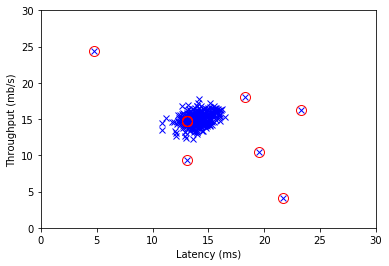

In [6]:
#visualization:Draw a red circle around those outliers
outliters = np.where(p_train < epsilon)

plt.plot(X[:,0],X[:,1],'bx')
plt.plot(X[outliters,0],X[outliters,1],'ro',lw=2, markersize=10,\
         fillstyle='none', markeredgewidth=1)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

In [7]:
# load the data2

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

data1 = sio.loadmat('ex8data2.mat')
X1 = data1['X']
Xval1 = data1['Xval']
yval1 = data1['yval']
print X1.shape,Xval1.shape,yval1.shape
print X1[:1]



(1000L, 11L) (100L, 11L) (100L, 1L)
[[  6.65311366  13.68970163  17.55284534 -11.93349739  -5.75640883
   15.43592131 -12.13675197   8.22412257  -4.88402408   5.34933534
   17.35137235]]


In [30]:
# multivariate_normal 多元高斯分布
from scipy import stats
def get_mean_cov(x):
    m,n = x.shape
    mu = np.mean(x,axis=0)#平均值
    Sigma = np.var(x, axis=0) #方差
    #Sigma = np.diagflat(Sigma) #对角矩阵,[[1,0,0],[0,1,0],[0,0,1]]
    Sigma = np.diag(Sigma)
    detSigma = np.linalg.det(Sigma) #行列式
    
    return mu,Sigma,detSigma

    
def mul_P(x,mu,sigma,detSigma):
    #x is vector =[n*1]
    n = x.shape[0]
    xx = x - mu #[n*1]
    #dot点乘
    p = np.exp(-0.5 * np.dot(xx.T.dot(np.linalg.pinv(sigma)), xx)) * \
            ((2*np.pi)**(-n/2) * (detSigma**(-0.5)))
    return p
    
        
mu1,Sigma,detSigma=get_mean_cov(X1)
print mu1.shape,Sigma.shape,Sigma[0,0],Sigma[1,1]  #compute correct
print detSigma #correct 
p_train1 = np.array([mul_P(x,mu1,Sigma,detSigma) for x in X1]).reshape(-1,1)
p_val1 = np.array([mul_P(x,mu1,Sigma,detSigma) for x in Xval1]).reshape(-1,1)


print p_train1[:2]
print p_val1[:2]

(11L,) (11L, 11L) 60.9748937269 53.2057218642
4.80014259158e+19


[[  2.96570877e-18]
 [  1.26751926e-18]]
[[  2.05276720e-22]
 [  6.92566186e-18]]


In [29]:
#test the cs
epsilon1,F1_1 = selectThreshold(yval1,p_val1)
print "Best epsilon found using cross-validation: %e"%(epsilon1)
print "Best F1 on Cross Validation Set:  %f"%(F1_1)
print "(you should see a value epsilon of about 1.38e-18)"
print "you should see a Best F1 value of  0.615385)"

print "Outliers found: %d"%(np.sum(p_train1 < epsilon1))



Best epsilon found using cross-validation: 5.494348e-19
Best F1 on Cross Validation Set:  0.615385
(you should see a value epsilon of about 1.38e-18)
you should see a Best F1 value of  0.615385)
Outliers found: 117
